In [1]:

import astropy.units as u
import numpy as np
import gala.potential as gp
import gala.dynamics as gd
from gala.dynamics import mockstream as ms
from gala.units import galactic
from astropy.coordinates import SkyCoord, Distance

import matplotlib.pyplot as plt

from tqdm import tqdm
from astropy.constants import G
from gala.units import galactic
import gala.coordinates as gc
import  h5py
import imageio
import seaborn as sns
import matplotlib as mpl
import matplotlib.animation as animation
import astropy.coordinates as astro_coord
import glob
import pandas as pd
sns.set_style("dark")
mpl.rc('xtick', labelsize=16) 
mpl.rc('ytick', labelsize=16) 
font = {'axes.titlesize'      : 'large',   # fontsize of the axes title
        'axes.labelsize'      : 'large', # fontsize of the x any y labels
        'size'   : 20}
import astropy.units as u
from astropy.io import ascii
import itertools
from scipy import stats
#paths

#paths
path_plot = '/users/caganze/research/stellarstreams/figures/paper/'
path_data = '/users/caganze/research/stellarstreams/data/rotating/'
isochrone_path='/users/caganze/research/stellarstreams/data/isochrones/'


from matplotlib.gridspec import GridSpec
%matplotlib inline
#%matplotlib notebook

In [2]:
#function definitions
def evolve_orbits_with_nbody(st_coord, pert_coord, pert_pot, time_dict):
    #evolve stream and nbody for a short period without releasing any stars
    w0 = gd.combine((st_coord, pert_coord,))
    particle_pot = [list([pert_pot]) + [gp.NullPotential(units=pert_pot.units)] * st_coord.shape[0]][0]
    
    nbody = gd.DirectNBody(w0, particle_pot, external_potential=MWPOT, save_all=True)

    return  nbody.integrate_orbit(**time_dict)

#function definitions
def evolve_orbits_only(st_coord, time_dict, units):
    #evolve stream and nbody for a short period without releasing any stars
    particle_pot = [ [gp.NullPotential(units=units)] * st_coord.shape[0]][0]
    
    nbody = gd.DirectNBody(st_coord, particle_pot, external_potential=MWPOT, save_all=True)

    return  nbody.integrate_orbit(**time_dict)


### These are the important definitions. The lines above are just to show how the stuff used in here are originally defined
def get_cyl_rotation(site_at_impact_w0): #borrowed from Adrian Price-Whelan's streampunch github repo
    L = site_at_impact_w0.angular_momentum()
    v = site_at_impact_w0.v_xyz

    new_z = v / np.linalg.norm(v, axis=0)
    new_x = L / np.linalg.norm(L, axis=0)
    new_y = -np.cross(new_x, new_z)
    R = np.stack((new_x, new_y, new_z))
    return R


def get_perturber_w0_at_impact(site_at_impact_w0, psi, v_rho, v_z, vpsi):

    # Get the rotation matrix to rotate from Galactocentric to cylindrical
    # impact coordinates at the impact site along the stream
    R = get_cyl_rotation(site_at_impact_w0)

    psi, v_rho, v_z, vpsi =  psi * u.rad, v_rho*u.km/u.s,  v_z * u.km/u.s, vpsi * u.rad/u.s

    # Define the position of the perturber at the time of impact in the
    # cylindrical impact coordinates:
    perturber_pos = astro_coord.CylindricalRepresentation(rho=0*u.kpc, 
                                                    phi=psi,
                                                    z=0*u.kpc) 

    # Define the velocity in the cylindrical impact coordinates:
    #maybe we want this to have the same vz as the stream?
    perturber_vel = astro_coord.CylindricalDifferential(
        d_rho=v_rho,
        d_phi=vpsi,
        d_z=v_z)

    # Transform from the cylindrical impact coordinates to Galactocentric
    perturber_rep = perturber_pos.with_differentials(perturber_vel)
    perturber_rep = perturber_rep.represent_as(
        astro_coord.CartesianRepresentation, astro_coord.CartesianDifferential)
    perturber_rep = perturber_rep.transform(R.T)

    pos = perturber_rep.without_differentials() + site_at_impact_w0.pos
    vel = perturber_rep.differentials['s'] + site_at_impact_w0.vel

    # This should be in Galactocentric Cartesian coordinates now!
    return gd.PhaseSpacePosition(pos, vel)

In [3]:
#animation
def plot_stream_at_particular_step(halo_and_stream, step):
    
    st=halo_and_stream[step][:-1]
    bd=halo_and_stream[step][-1]
    
    fig, ax=plt.subplots(ncols=3, figsize=(12, 4))
    #plot r vs z
    ax[0].scatter(st.pos.x, st.pos.y, s=1)
    ax[0].scatter(bd.pos.x, bd.pos.y, s=100, c='b')
    

    ax[1].scatter(st.pos.x, st.pos.z, s=1)
    ax[1].scatter(bd.pos.x, bd.pos.z, s=100, c='b')
    
    ax[-1].scatter(st.pos.y, st.pos.z, s=1)
    ax[-1].scatter(bd.pos.y, bd.pos.z, s=100, c='b')
    
    #for a in ax:
    ax[0].set(xlabel='x (kpc)', ylabel='y (kpc)')
    ax[1].set(xlabel='x (kpc)', ylabel='z (kpc)')
    ax[-1].set(xlabel='y (kpc)', ylabel='z (kpc)')
    
    plt.tight_layout()
        
    # IMPORTANT ANIMATION CODE HERE
    # Used to keep the limits constant

    # Used to return the plot as an image rray
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    return image

def animate_collision(halo_and_stream, steps, filename):

    kwargs_write = {'fps':1, 'quantizer':'nq'}
    _= imageio.mimsave(path_plot+'/'+ filename+'vzonly.gif',\
                       [ plot_stream_at_particular_step(halo_and_stream, step) for step in \
                                         steps], \
                       fps=5)
    return 

In [4]:
 #control stream's length (10/8 for 30 and 12/8 for 50)
file_prefix='simpler_rgc10'

In [5]:
#some global parameters
#galactocentric reference frame
v_sun = astro_coord.CartesianDifferential([11.1, 220 + 24.0, 7.25]*u.km/u.s)
galcen_frame =astro_coord.Galactocentric(galcen_distance=8.*u.kpc,
                                    galcen_v_sun=v_sun)


#potential of the galaxy
MWPOT = gp.MilkyWayPotential()
H = gp.Hamiltonian(MWPOT)


#stream potential
gd1_mass = 3e4 * u.Msun
gd1_pot = gp.PlummerPotential(m=gd1_mass, b=5*u.pc, units=galactic)
df = ms.FardalStreamDF()

In [6]:
#for next time --> use some Pal 5 papers and orbits 
#present day coordinates
coord=SkyCoord(ra=229.0220833333333*u.degree, dec=-0.1113888*u.degree,  unit=(u.hourangle, u.deg), 
               pm_ra_cosdec=-2.75*u.mas/u.yr, pm_dec=-2.69*u.mas/u.yr, distance=21*u.kpc, 
              radial_velocity= -57.4*u.km/u.s)

present_pos=gd.PhaseSpacePosition(coord.transform_to(galcen_frame).cartesian)

tfinal=1000*u.Myr
trun= 750*u.Myr

pal5_orbit=H.integrate_orbit(present_pos, dt=-1*u.Myr, t1=0*u.Gyr, t2=-tfinal)

#pal 
pal5_w0= pal5_orbit[-1]

/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/integrate/timespec.py:35: UserWarning: The argument 'nsteps' is deprecated and will be removed in a future version.Use 'n_steps' instead.
  warn("The argument 'nsteps' is deprecated and will be removed in a future version."


[False False False ... False False False]


[Text(0.5, 0, 'y (kpc)'), Text(0, 0.5, 'z (kpc)')]

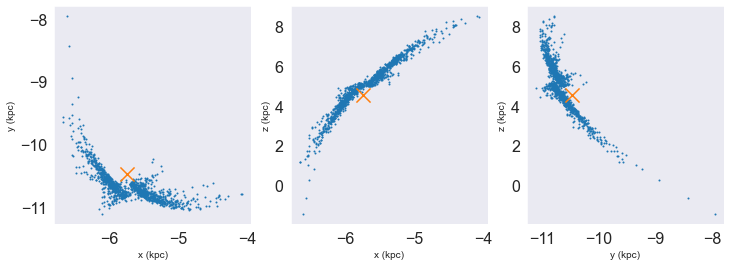

In [7]:
#now run a stream forward and choose an impact site
generation_time= {'t2':trun, 'nsteps': 300, 't1': 0*u.Myr}


#integrate back to create a stream
gen_gd1 = ms.MockStreamGenerator(df, MWPOT)# progenitor_potential=gd1_pot)
stream, nbody = gen_gd1.run(pal5_w0, gd1_mass,**generation_time, n_particles=2)
w0_now = gd.PhaseSpacePosition(stream.data, stream.vel)

#integrate orbit back
orbit = MWPOT.integrate_orbit(w0_now, dt=-1*u.Myr, nsteps= int(trun.to(u.Myr).value))
old_stream = orbit[-1]

#choose impact position somewhere in the tail
impact_bool1= (((old_stream.pos.x.value-np.nanmedian(old_stream.pos.x.value))**2+
                                    (old_stream.pos.y.value-np.nanmedian(old_stream.pos.y.value))**2+
                                    (old_stream.pos.z.value-np.nanmedian(old_stream.pos.z.value))**2)**0.5) >=2.7

impact_bool0= (((old_stream.pos.x.value-np.nanmedian(old_stream.pos.x.value))**2+
                                    (old_stream.pos.y.value-np.nanmedian(old_stream.pos.y.value))**2+
                                    (old_stream.pos.z.value-np.median(old_stream.pos.z.value))**2)**0.5)  <=2.8

impact_site= np.logical_and(impact_bool1, impact_bool0)

print (impact_site)

site_at_impact_w0=gd.PhaseSpacePosition(pos=np.mean(old_stream.pos[impact_site], axis=0), \
                                          vel=np.mean(old_stream.vel[impact_site], axis=0))
#visualize
fig, ax=plt.subplots(ncols=3, figsize=(12, 4))
ax[0].scatter(old_stream.pos.x, old_stream.pos.y, s=1)
ax[1].scatter(old_stream.pos.x, old_stream.pos.z, s=1)
ax[-1].scatter(old_stream.pos.y, old_stream.pos.z, s=1)

ax[0].scatter(site_at_impact_w0.pos.x, site_at_impact_w0.pos.y, s=200, marker='x')
ax[1].scatter(site_at_impact_w0.pos.x, site_at_impact_w0.pos.z, s=200, marker='x')
ax[-1].scatter(site_at_impact_w0.pos.y, site_at_impact_w0.pos.z, s=200, marker='x')

ax[0].set(xlabel='x (kpc)', ylabel='y (kpc)')
ax[1].set(xlabel='x (kpc)', ylabel='z (kpc)')
ax[-1].set(xlabel='y (kpc)', ylabel='z (kpc)')
#vxstream, vystream, vzstream not defined in this file but its just the velocity of the stream
#jk

In [27]:
stream.pos

<CartesianRepresentation (x, y, z) in kpc
    [(-6.56726037, -15.01442395, -1.26542596),
     (-6.63364512, -14.62198647, -2.02987426),
     (-6.70918737, -12.92344451, -4.10609832), ...,
     (-6.77948263, -14.21045571, -2.74189763),
     (-6.65132869, -13.97919139, -2.7022677 ),
     (-6.6431571 , -14.03547205, -2.72293688)]>

In [8]:
#choose the subhalo properties
frac=100.0
vpsi= ((1*u.km/u.s)/(0.01*u.kpc)).to(u.rad/u.s, u.dimensionless_angles()).value
impact_vector=frac*(np.array([(1/frac)*(3*np.pi/2), 1, 1, (1/frac)*np.pi/2]))
perturb= get_perturber_w0_at_impact(site_at_impact_w0, *impact_vector)
print (impact_vector)
print (perturb.xyz, perturb.v_xyz)

[  4.71238898 100.         100.           1.57079633]
[ -5.74717519 -10.46766352   4.52969381] kpc [  -9.48538987  169.16901765 -279.65065867] km / s


In [9]:
TIME_BACK= 40*u.Myr
dt=1.*u.Myr
NSTEPS_COL=int((TIME_BACK/dt).value)

In [10]:
#integrate this position a little bit backwards
# run both the pertuber and the subhalo as potential object for a few Myr
col_time= {'nsteps':NSTEPS_COL, 'dt': -dt*u.Myr}

orbi= H.integrate_orbit(perturb,  **col_time)

halo_x=gd.PhaseSpacePosition(pos=orbi[-1].xyz, vel=orbi[-1].v_xyz)

print (orbi[-1].xyz, orbi[0].xyz)

#mean stream position
st_x=gd.PhaseSpacePosition(pos= old_stream.xyz,
                            vel=[old_stream.v_x.value, \
                                 old_stream.v_y.value,\
                                 old_stream.v_z.value]*u.kpc/u.Myr)

[ -4.50423486 -15.51626541  14.66575587] kpc [ -5.74717519 -10.46766352   4.52969381] kpc


In [11]:
TIME_BACK*2, dt*NSTEPS_COL

(<Quantity 80. Myr>, <Quantity 40. Myr>)

In [12]:
# run both the pertuber and the subhalo as potential object for a few Myr
col_time= {'t2':TIME_BACK*2, 'nsteps': NSTEPS_COL, 't1': 0.*u.Myr}

mhalo=10**6
rhalo=1005*((mhalo/10**8)**0.5)
#define the potential of the subhalo pummer sphere for now
subhalo_pot=gp.HernquistPotential(mhalo*u.Msun,  rhalo*u.pc, units=galactic)

halo_and_stream= evolve_orbits_with_nbody(st_x, halo_x, subhalo_pot, col_time)

In [13]:
np.shape(halo_and_stream)

(40, 1201)

/var/folders/p5/jqfspzln0z965dsfd1pj_5900000gp/T/ipykernel_12090/2446855131.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax=plt.subplots(ncols=3, figsize=(12, 4))


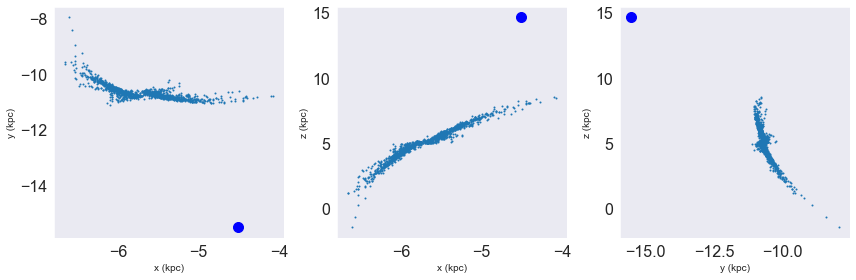

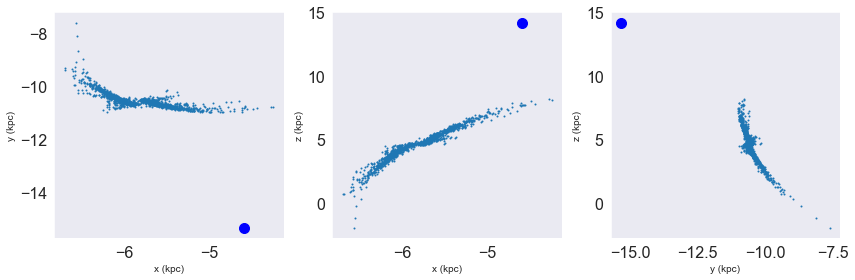

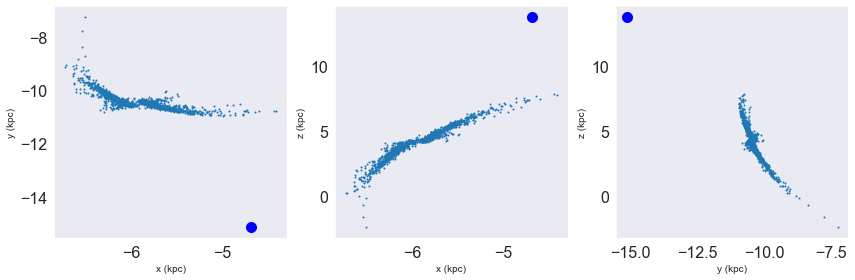

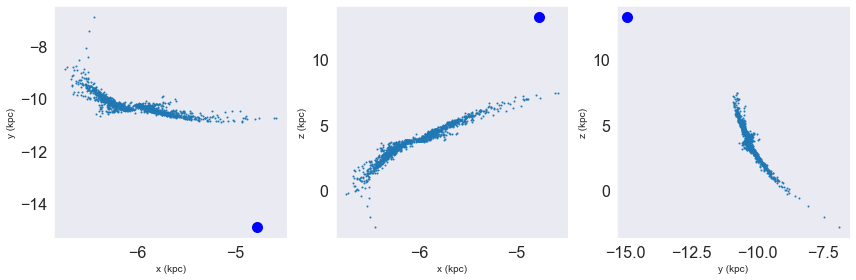

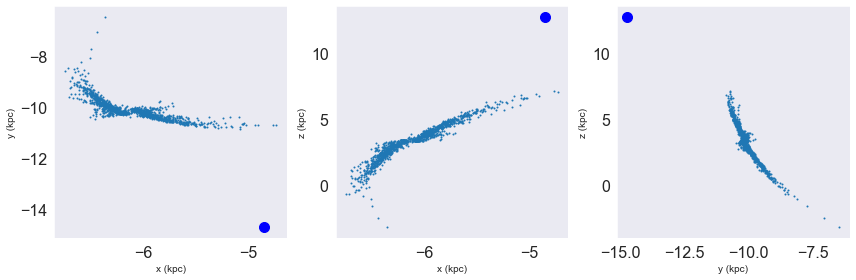

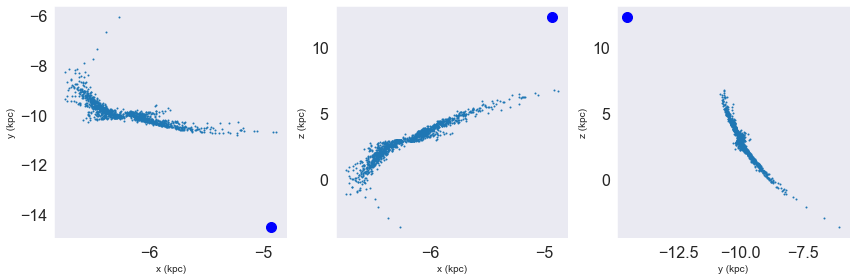

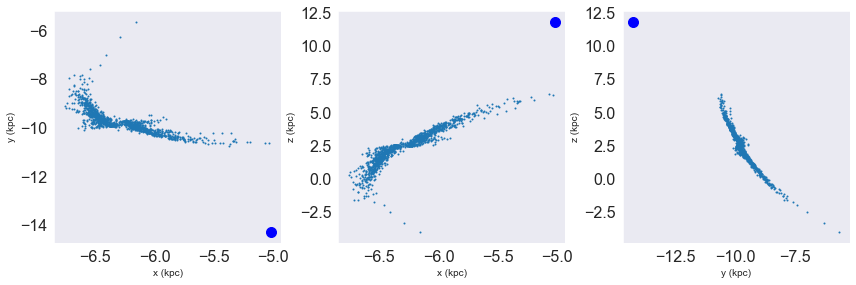

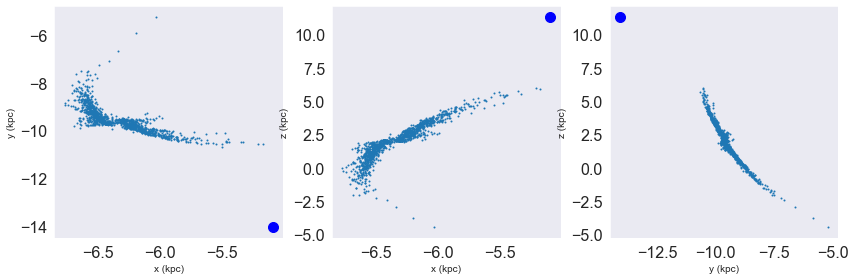

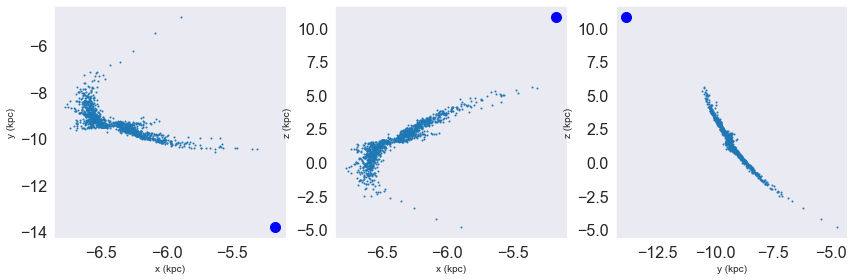

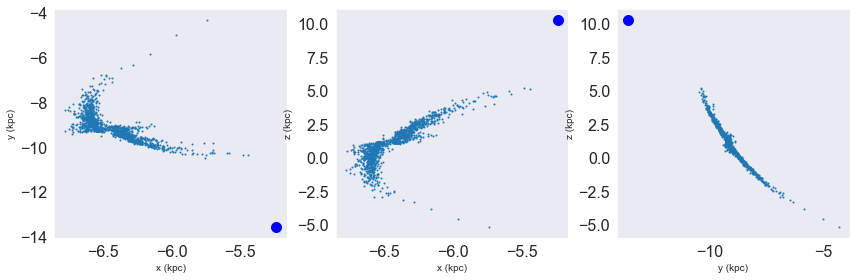

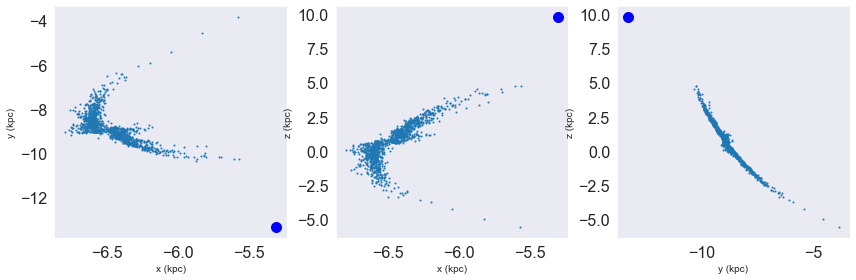

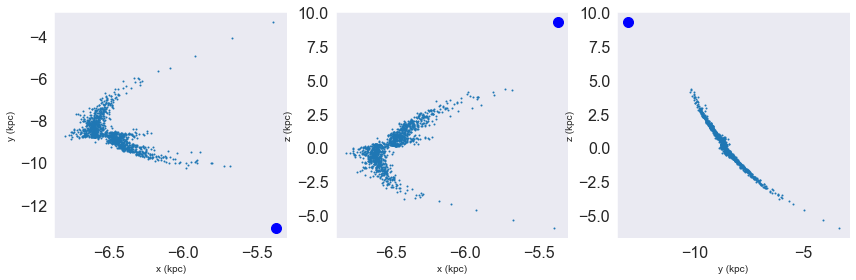

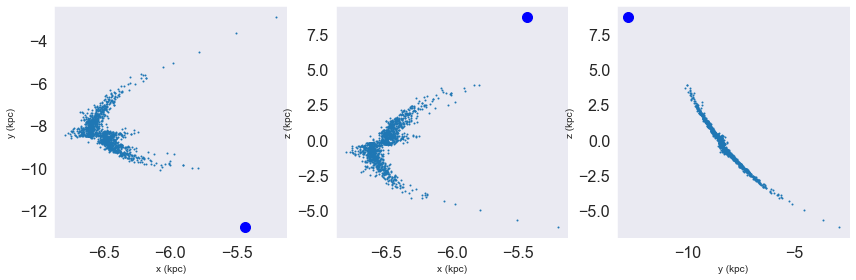

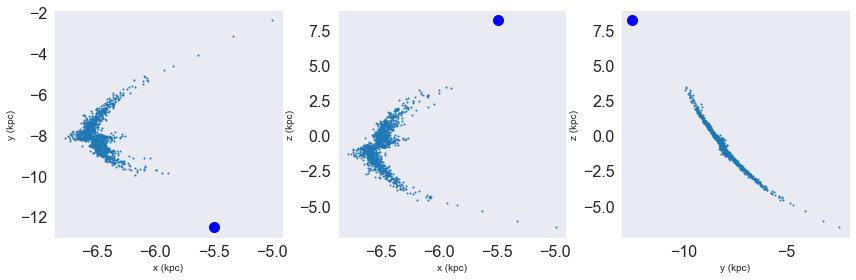

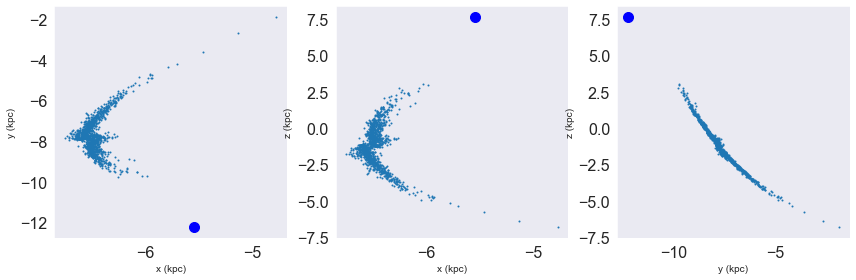

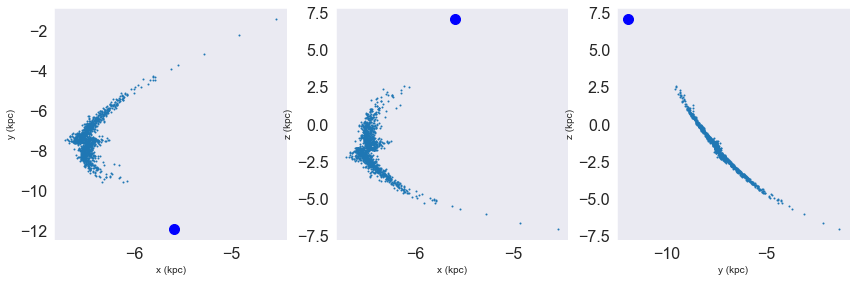

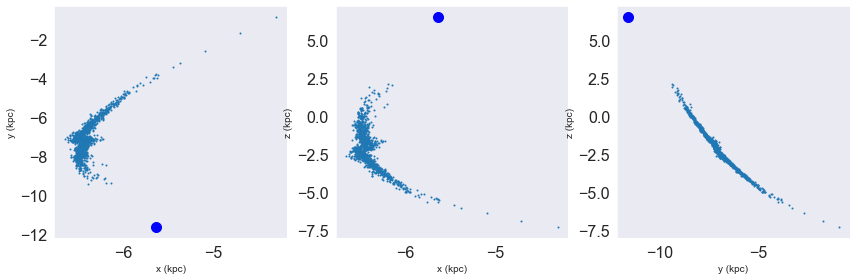

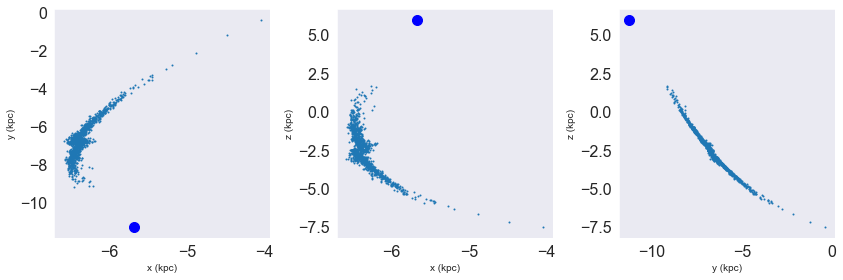

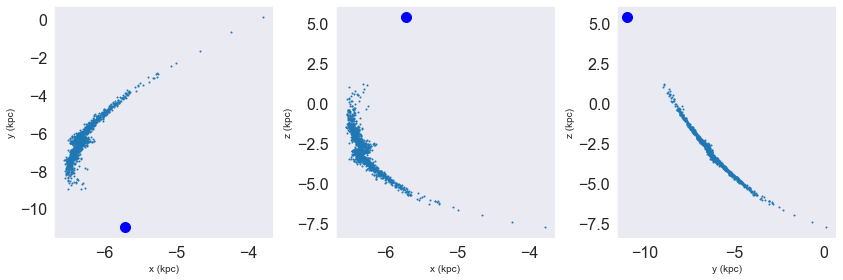

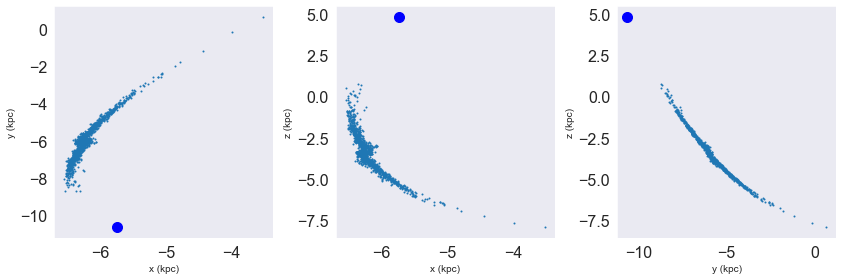

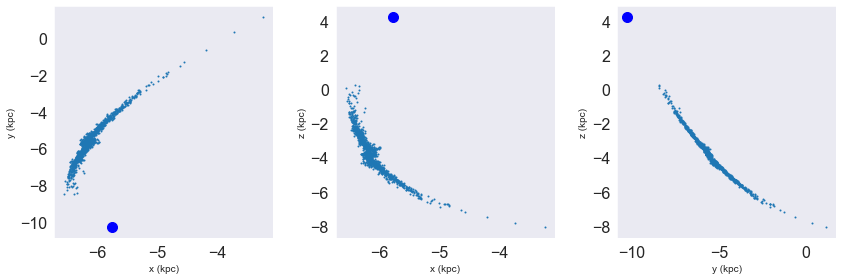

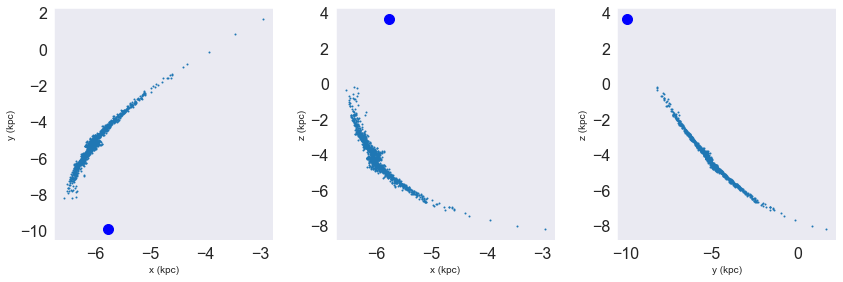

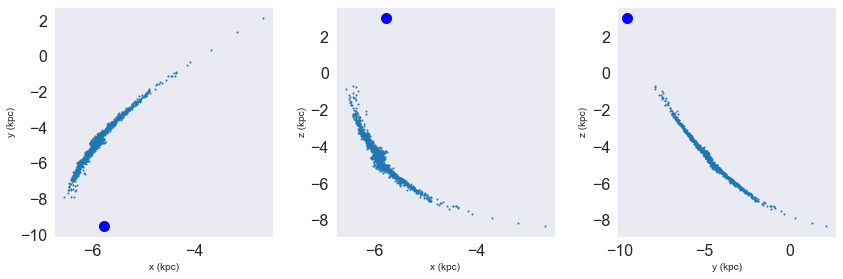

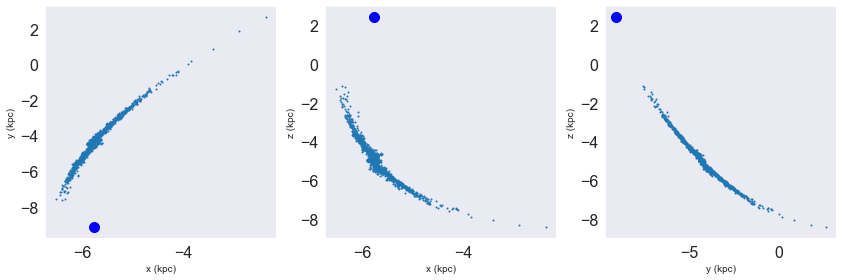

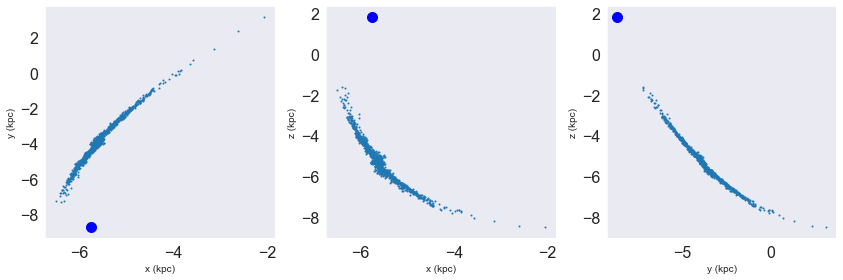

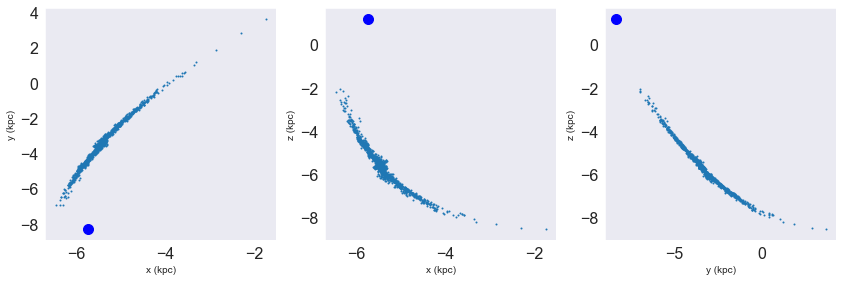

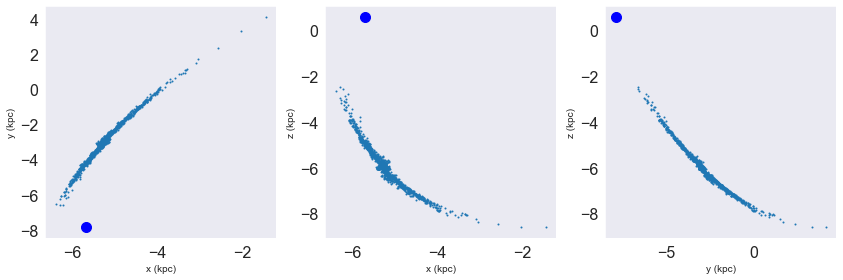

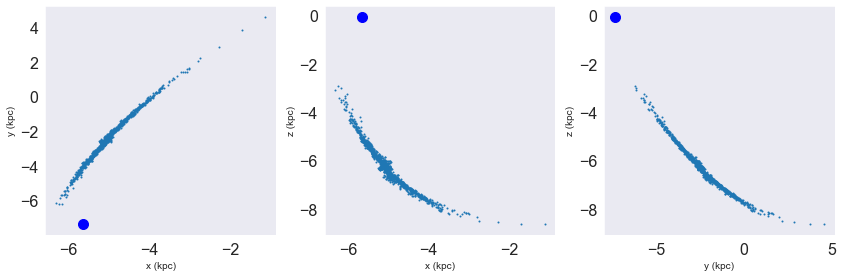

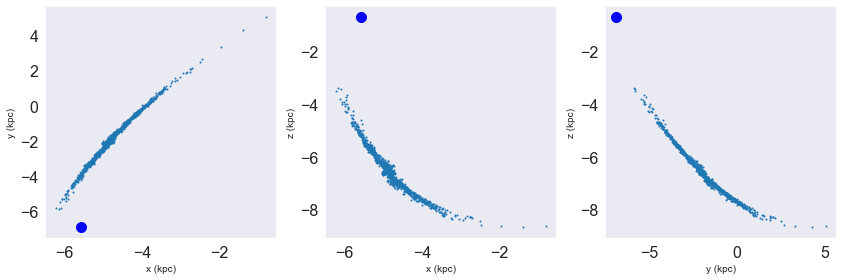

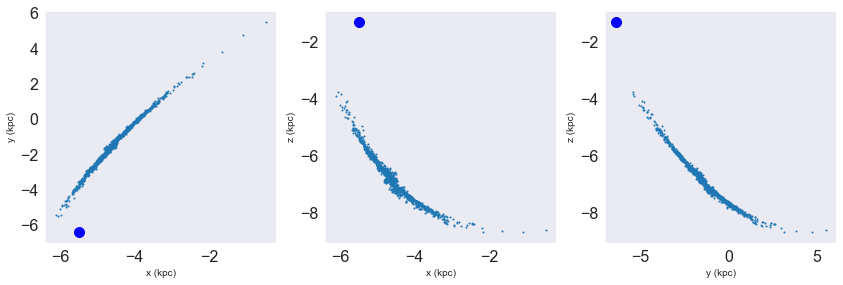

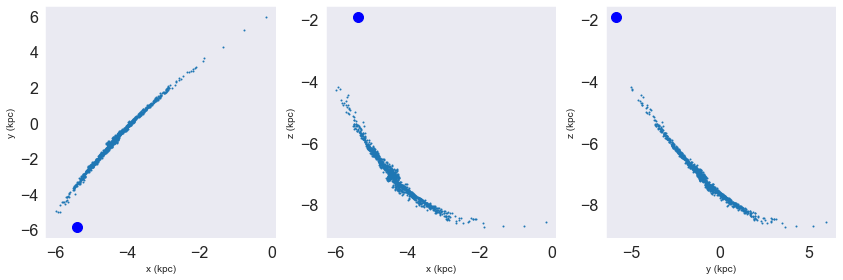

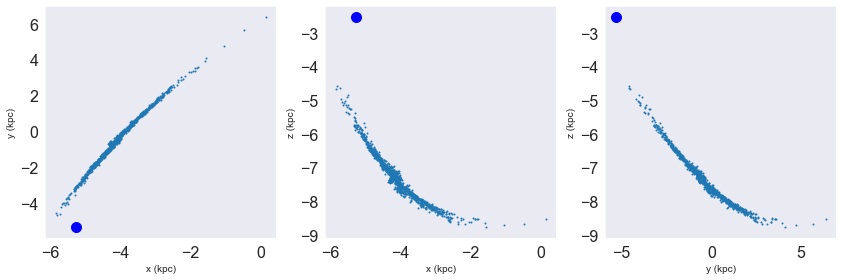

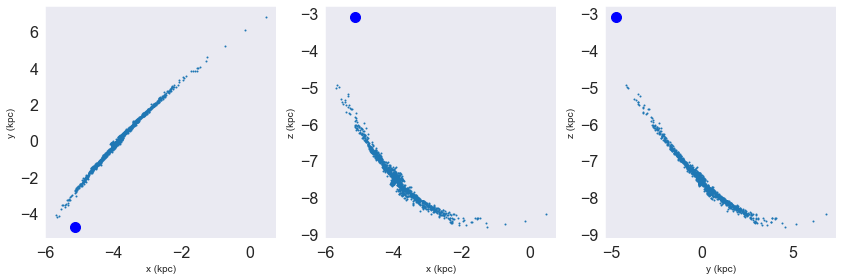

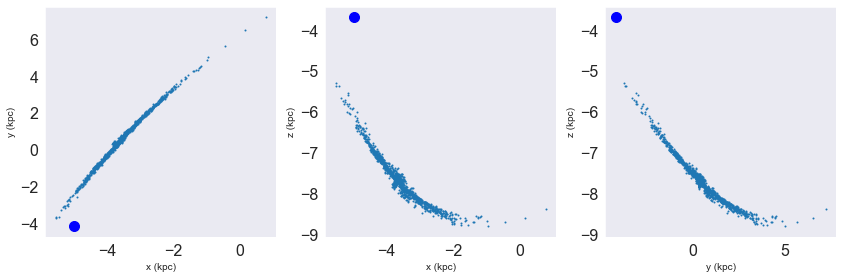

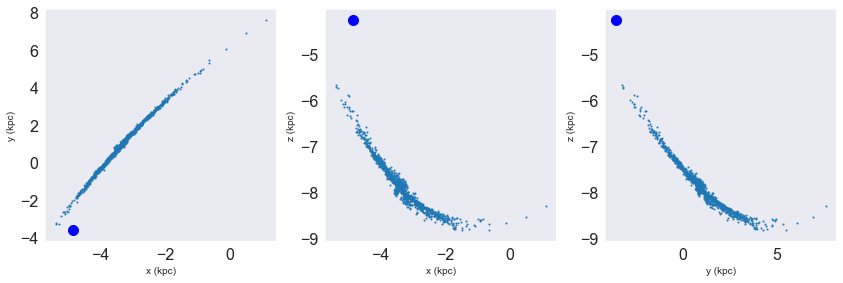

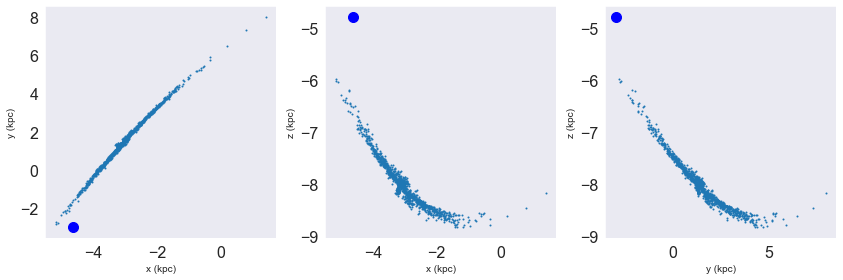

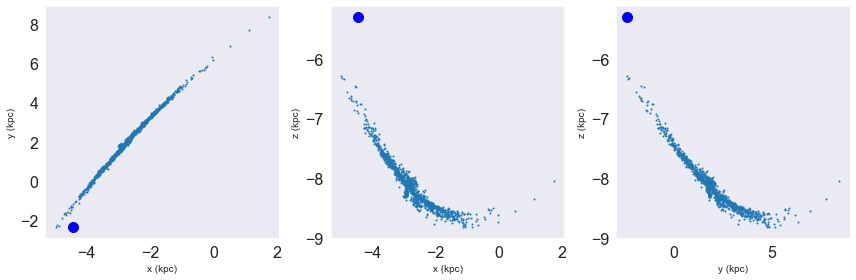

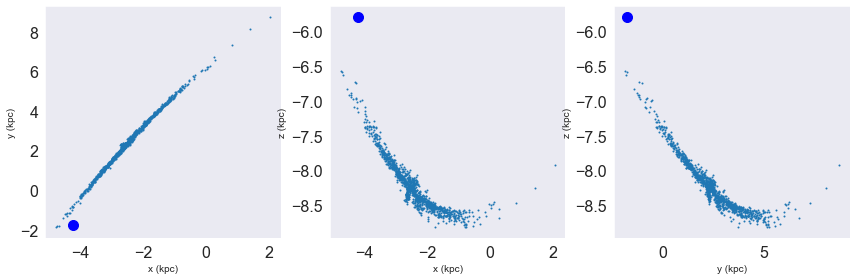

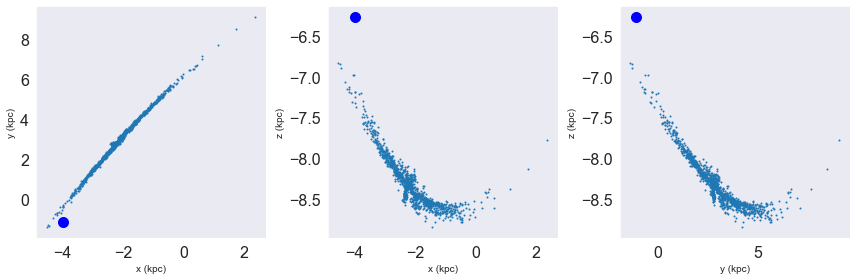

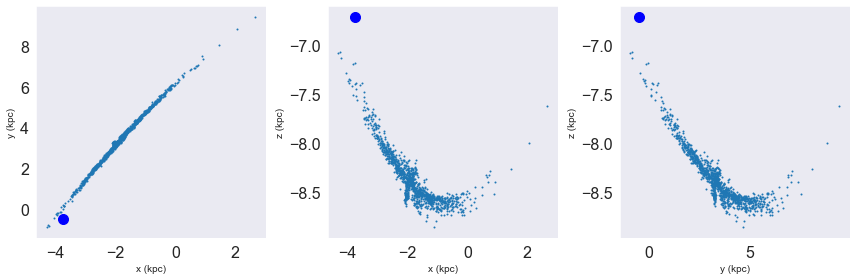

In [14]:
animate_collision(halo_and_stream, np.arange( NSTEPS_COL), file_prefix)


In [15]:
s=halo_and_stream[-1][:-1]

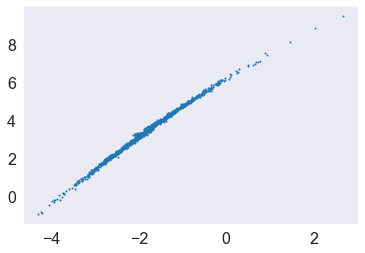

In [16]:
fig, ax=plt.subplots()
ax.scatter(s.pos.x, s.pos.y, s=1)

In [17]:

final_time={'t1': 0.*u.Myr, 't2': 1*u.Gyr, 'nsteps': 100}

final_stream= evolve_orbits_only(s, final_time, galactic)

In [18]:
final_stream

<Orbit cartesian, dim=3, shape=(100, 1200)>

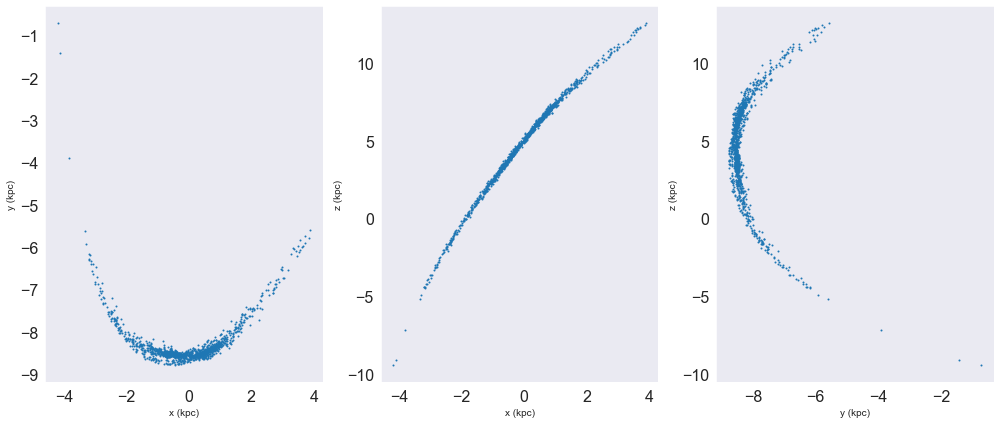

In [19]:
fig, ax=plt.subplots(ncols=3, figsize=(14, 6))
ax[0].scatter(final_stream[-1].x, final_stream[-1].y, s=1)
ax[1].scatter(final_stream[-1].x, final_stream[-1].z, s=1)
ax[-1].scatter(final_stream[-1].y,final_stream[-1].z, s=1)
ax[0].set(xlabel='x (kpc)', ylabel='y (kpc)')#, xlim=[-2, 4], ylim=[-2, 4])
ax[1].set(xlabel='x (kpc)', ylabel='z (kpc)')#, xlim=[-2, 4], ylim=[-10, -8])
ax[2].set(xlabel='y (kpc)', ylabel='z (kpc)')#, xlim=[-2, 4], ylim=[-10, -8
plt.tight_layout()

In [20]:
#save
final_stream_coord=SkyCoord(x=final_stream[-1].x,
                            y=final_stream[-1].y,
                            z=final_stream[-1].z, 
                            v_x=final_stream[-1].v_x,
                            v_y=final_stream[-1].v_y,
                            v_z=final_stream[-1].v_z,
                           frame=galcen_frame)

In [21]:
#save this 
filename= file_prefix+'_direct_nbody{:.2e}'.format(mhalo)
final_data={'stream': final_stream_coord, 'prog': None}
np.save(path_data+'/{}.npy'.format(filename), final_data)

In [22]:
final_stream.x

<Quantity [[-2.01602304, -1.9960852 , -1.71497365, ..., -0.78206611,
            -2.60924769, -2.53199521],
           [-0.47137261, -0.46994772, -0.16400055, ...,  0.77893398,
            -1.08755643, -1.00623208],
           [ 1.09494165,  1.07787216,  1.39596805, ...,  2.31223943,
             0.48695511,  0.56903328],
           ...,
           [ 3.46428605,  2.38237861, -0.29659915, ...,  2.39808235,
             2.02242363,  2.02464491],
           [ 2.49134308,  1.33789897, -1.36320876, ...,  1.35638125,
             0.95433114,  0.9675647 ],
           [ 1.44869538,  0.24647761, -2.33095665, ...,  0.26847417,
            -0.15003713, -0.12614874]] kpc>

In [23]:
filename

'simpler_rgc10_direct_nbody1.00e+06'

In [24]:
present_pos.v_xyz

<Quantity [ -45.1797587 , -138.61432168,  -12.50849119] km / s>

In [25]:
file_prefix

'simpler_rgc10'